# Lab 4: Non-negative Matrix Factorization

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MSc - TD4"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L4_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy             as np
import matplotlib.pyplot as plt
import seaborn           as sns
from sklearn.utils       import check_random_state
from sklearn.datasets    import fetch_olivetti_faces

%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds        = {'alpha' : 0.25, 's' : 80, 'linewidths':0}

dataset          = fetch_olivetti_faces(shuffle=True)
faces            = dataset.data.T #on représente chaque image par une colonne, en accord avec le cours
faces[3523][338] = 1e-2 #l'un des éléments de faces est nul, ce qui bloque la divergence de KL

In [2]:
faces.shape

(4096, 400)

## NMF

Loss (Regularized Froebnius): $\mathcal{L}(W, H) = \frac{1}{2}\|X-W H\|_{F}^{2}+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates from [Lee and Seung, 1999]: 

\begin{array}{c}
W \leftarrow W \circ \frac{X H^{\top}}{W (H H^{\top} + {\color{red} \nu I_r})} \\
H \leftarrow H \circ \frac{W^{\top} X - {\color{red} \lambda 1_{r \times n}}}{(W^{\top} W + {\color{red} \mu I_r})H}
\end{array}

Loss (Regularized KL divergence): $\mathcal{L}(W, H) = KL(X, WH)+ \color{red}{\frac{\mu}{2}\|H\|_{F}^{2}+\lambda\|H\|_{1}+\frac{\nu}{2}\|W\|_{F}^{2}}$

Algorithm (multiplicative updates): Reference: https://www-n.oca.eu/aferrari/MAHI/CDeMolMAHI13.pdf

\begin{array}{c}
W \leftarrow \frac{2A}{B+\sqrt{B\circ B \ + \ 4\nu A } } \\
\end{array}

where $A \ = \ W\ \circ \frac{X}{WH}\ H^{T} ,\ \  B = 1_{p\times n }\ H^{T} $

\begin{array}{c}
H \leftarrow \frac{2C}{D+\sqrt{D\circ D \ + \ 4\mu C } } \\
\end{array}

where $C = H\ \circ \ W^{T}\ \frac{X}{WH} ,\ \  D = \lambda 1_{r\times n}\ + \ W^{T}1_{p\times n} $



Fill in the following NMF class:

In [3]:
from scipy.special import kl_div


class MYNMF():
    
    """ Class for logistic regression:
    
    Attributes:                                                                                 
    -----------                                                Default value
    n_components_ : integer,  unknown dimension of W and H   | 20                
    max_iter_     : integer,  maximum number of iterations   | 60
    epsilon_      : float,    epsilon coefficient            | 1e-4
    loss_         : str,      {"Frobenius", "KL"}            | Frobenius
    W_            : np.array, W Matrix factor                | None
    H_            : np.array, H Matrix factor                | None
    W_history     : list,     W Matrix history               | []
    H_history     : list,     H Matrix history               | []
    loss_history  : list,     history of loss                | []
    random_state  : int,      for the random initialization  | 42
    """
    
    def __init__(self, n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42):
        
        self.n_components_ = n_components
        self.max_iter_     = max_iter
        self.epsilon_      = epsilon
        self.loss_         = loss
        self.update_rule_  = update_rule
        self.W_            = None
        self.H_            = None
        self.W_history     = []
        self.H_history     = []
        self.loss_history  = []
        self.random_state  = random_state
        self.components_   = None    # shape (r, p)
        
    def fit_transform(self, data, mu=5e-3,  nu=5e-3, lambd=1e-3):
        
        """ Find the factor matrices W and H for matrix factorization of data
        
        Parameters:
        -----------                                 Default value       
        data  : (p, n) np.arrayData, matrix       | 
        mu    : float, regularization parameter   | 5e-3
        lambd : float, regularization parameter   | 1e-3
        nu    : float, regularization parameter   | 5e-3
        
        Returns:
        -----
        embedding: (p, r) np.array
                    Embedding matrix        
        """        
        #TODO
        
        p,n = data.shape
        
        # Initialization of W and H:
        rng = np.random.default_rng(seed=self.random_state)
        self.W_ = rng.random((p, self.n_components_))
        self.H_ = rng.random((self.n_components_, n))
        #self.W_history.append(self.W_)
        #self.H_history.append(self.H_)
        
        # Multiplicative Updates according to Update rules:
        for i in range(self.max_iter_):
            
            if self.update_rule_ == 'Frobenius':
               
                # Update W:
                W_N = data @ self.H_.T + self.epsilon_ 
                W_D = self.W_ @ self.H_ @ self.H_.T + nu*self.W_ @ np.identity(self.n_components_) + self.epsilon_
                newW = np.multiply(self.W_, W_N/W_D) 
                self.W_ = newW.copy()
                # Update H:
                H_N = self.W_.T @ data - lambd*np.ones((self.n_components_, n))+ self.epsilon_
                H_D = self.W_.T @ self.W_ @ self.H_ + mu* np.identity(self.n_components_)@self.H_ + self.epsilon_
                newH = np.multiply(self.H_, H_N/H_D)
                self.H_ = newH.copy()

                self.W_history.append(self.W_)
                self.H_history.append(self.H_)
                
               
                
            elif self.update_rule_ == 'Kullback-Leibler':
                '''
                # The following updates do not involve regularization terms:
                # Update W:
                W_N = (data/(self.W_@self.H_))@self.H_.T
                W_D = np.ones((p,n)) @ self.H_.T
                newW = np.multiply(self.W_, W_N/W_D)
                self.W_ = newW.copy()
                # Update H:
                H_N = self.W_.T @ (data/(self.W_@self.H_))
                H_D = self.W_.T @ np.ones((p,n))
                newH = np.multiply(self.H_, H_N/H_D)
                self.H_ = newH.copy()
                
                self.W_history.append(self.W_)
                self.H_history.append(self.H_)
                '''
                
                # The following updates involve regularization terms:
                # Update W:
                A = np.multiply(self.W_, ((data/(self.W_ @self.H_))) @ self.H_.T) + self.epsilon_
                B = np.ones((p,n)) @ self.H_.T 
                newW = 2*A/(B + np.sqrt(B*B + 4*nu*A)) 
                self.W_ = newW.copy()
                
                # Update H:
                C = np.multiply(self.H_, self.W_.T @(data / (self.W_@self.H_))) + self.epsilon_
                D = lambd * np.ones((self.n_components_,n)) + self.W_.T @ np.ones((p,n)) 
                newH = 2*C/(D + np.sqrt(D*D + 4*mu*C)) 
                self.H_ = newH.copy()
                
                self.W_history.append(self.W_)
                self.H_history.append(self.H_)
                
                
            else:
                print('There is an error about the form of Update rules')
                break
            
        
        # Calculate loss function according to the norm of distance:
            if self.loss_ == 'Frobenius':
            
                error = np.sum(np.array(data - self.W_@self.H_)**2)
                self.loss_history.append(error)
            
            elif self.loss_ == 'Kullback-Leibler':
            
                error = np.sum(kl_div(data, self.W_@self.H_))
                self.loss_history.append(error)
            
            else:
                print('There is an error about the norm of loss function')          
            
            
            
    def predict_label(self, X):
        """ Predict labels for X : cluster hard-assignment
        
        Parameters:
        -----------
        X: (p, n) np.array, data matrix
        
        Returns:
        -----
        label assignment : (n, ) np.array, Its elements are the predicted classes, from 0 to r-1
        """
        #TODO
        
        index_W = self.loss_history.index(min(self.loss_history))
        
        return self.W_history[index_W]
        
        
        
    def predict_proba(self, X):
        """ Predict probabilities of different classes for X :  cluster soft-assignment
        
        Parameters:
        -----------
        X: (p, n) np.array
            New data matrix
        
        Returns:
        -----
        label_assignment : (r, n) np.array
                          Its elements are the probabilities for different classes
        """
        #TODO
        
        index_H = self.loss_history.index(min(self.loss_history))
        
        return self.H_history[index_H]
        

## Hyperparameter optimization for Frobenius norm

### Regularization parameter : mu

when mu = 0.001  loss error is min


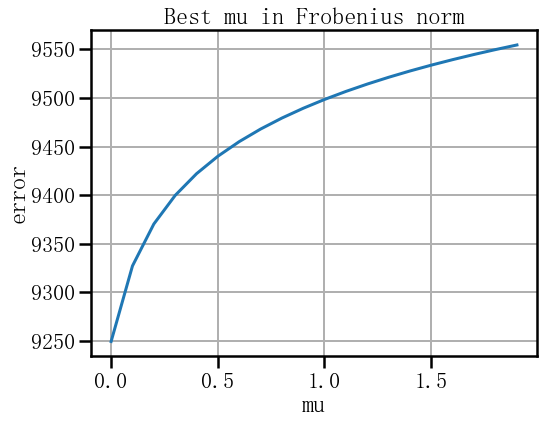

In [7]:
#TODO : find best mu
# Try different values of mu parameter and observe the Frobenius distance between X and WH:


mu_list = np.arange(0.001, 2, 0.1)
mu_min_loss = []
for i in mu_list:
    nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42)
    nmf.fit_transform(data=faces.T, mu=i,  nu=5e-3, lambd=1e-3)
    mu_min_loss.append(min(nmf.loss_history))

print('when mu = {}'.format(mu_list[mu_min_loss.index(min(mu_min_loss))]), ' loss error is min')
plt.figure(figsize=(8,6))
plt.plot(mu_list, mu_min_loss)
plt.xlabel('mu')
plt.ylabel('error')
plt.grid()
plt.title('Best mu in Frobenius norm');

### Regularization parameter : nu

when nu = 0.001  loss error is min


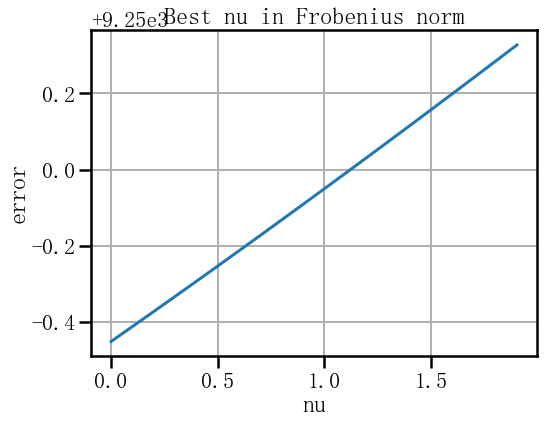

In [9]:
# TODO : find best nu
# Using best mu observed from the graph above, 
# try different values of nu and observe the Frobenius distance between X and WH :

nu_list = np.arange(0.001, 2, 0.1)
nu_min_loss = []
for i in nu_list:
    nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius',random_state=42)
    nmf.fit_transform(data=faces.T, mu=0.001,  nu=i, lambd=1e-3)
    nu_min_loss.append(min(nmf.loss_history))

print('when nu = {}'.format(nu_list[nu_min_loss.index(min(nu_min_loss))]), ' loss error is min')
plt.figure(figsize=(8,6))
plt.plot(nu_list, nu_min_loss)

plt.xlabel('nu')
plt.ylabel('error')
plt.grid()
plt.title('Best nu in Frobenius norm')
plt.rc('axes', unicode_minus=False); # dealing with a warning


### Regularization parameter : lambda

when lambd = 0.99  loss error is min


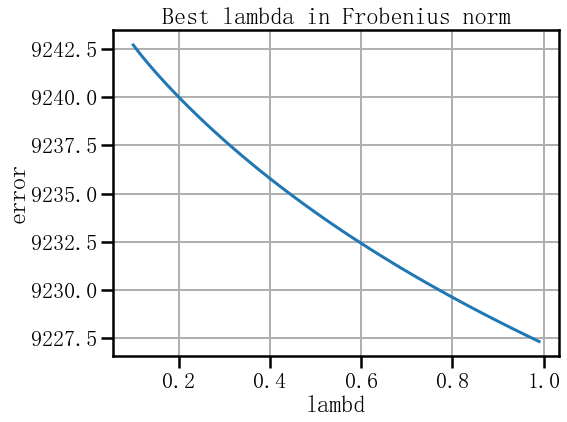

In [10]:
#TODO : find best lambda
# Using best mu and best nu observed from the graph above, 
# try different values of lambda and observe the Frobenius distance between X and WH :


lambd_list = np.arange(0.1, 1, 0.01)
lambd_min_loss = []
for i in lambd_list:
    nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42)
    nmf.fit_transform(data=faces.T, mu=0.001,  nu=0.001, lambd=i)
    lambd_min_loss.append(min(nmf.loss_history))

print('when lambd = {:.3}'.format(lambd_list[lambd_min_loss.index(min(lambd_min_loss))]), ' loss error is min')
plt.figure(figsize=(8,6))
plt.plot(lambd_list, lambd_min_loss)
plt.xlabel('lambd')
plt.ylabel('error')
plt.grid()
plt.title('Best lambda in Frobenius norm');

In [ ]:
# From the elbow curve, we see that as lambda increases, the frobenius distance decreases. 
# I also tried to larger the testing scale, it seems that when lambda = 5, the min distance is obtained
# While a large value of lambda would influence the results of multiplicative updates
# Since the decreasing speed of errors is very small, it seems larger lambda has bad effects on model
# Therefore I prefer to take a value of 0.1 here 

In [19]:
#TODO : check results for mu, nu and lambda with new obtained regularization parameters

nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius',random_state=42)
nmf.fit_transform(data=faces.T, mu = 0.001,  nu=0.001, lambd=0.1)
print(min(nmf.loss_history))

9242.696268271071


## Hyperparameter optimization for KL divergence  norm

### Regularization parameter : mu

when mu = 0.001  loss error is min


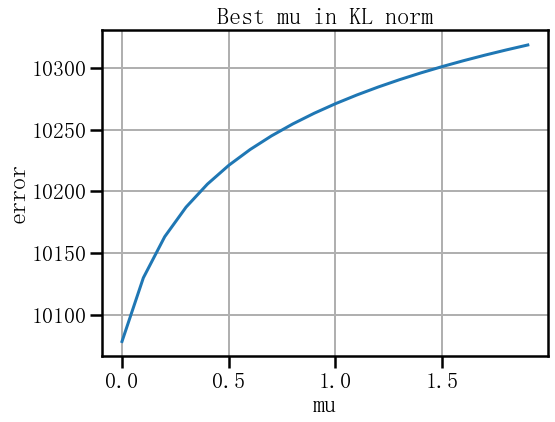

In [12]:
#TODO : find best mu
# Try different values of mu parameter and observe the Kullback-Leibler distance between X and WH:


mu_list = np.arange(0.001, 2, 0.1)
mu_min_loss = []
for i in mu_list:
    nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler', random_state=42)
    nmf.fit_transform(data=faces.T, mu=i,  nu=5e-3, lambd=1e-3)
    mu_min_loss.append(min(nmf.loss_history))

print('when mu = {}'.format(mu_list[mu_min_loss.index(min(mu_min_loss))]), ' loss error is min')
plt.figure(figsize=(8,6))
plt.plot(mu_list, mu_min_loss)
plt.xlabel('mu')
plt.ylabel('error')
plt.grid()
plt.title('Best mu in KL norm');

### Regularization parameter : nu

when nu = 0.001  loss error is min


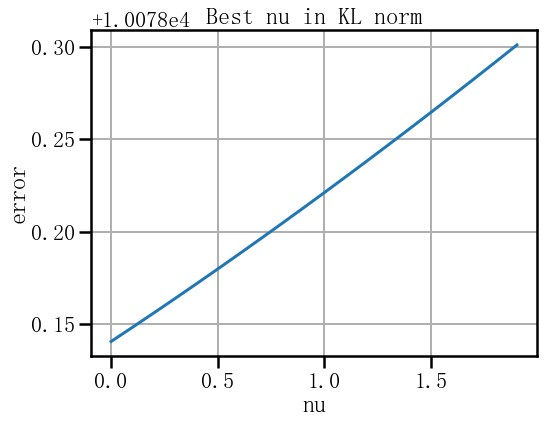

In [15]:
# TODO : find best nu
# Using best mu observed from the graph above, 
# try different values of nu and observe the Kullback-Leibler distance between X and WH :

nu_list = np.arange(0.001, 2, 0.1)
nu_min_loss = []
for i in nu_list:
    nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler',random_state=42)
    nmf.fit_transform(data=faces.T, mu=0.001,  nu=i, lambd=1e-3)
    nu_min_loss.append(min(nmf.loss_history))

print('when nu = {}'.format(nu_list[nu_min_loss.index(min(nu_min_loss))]), ' loss error is min')
plt.figure(figsize=(8,6))
plt.plot(nu_list, nu_min_loss)

plt.xlabel('nu')
plt.ylabel('error')
plt.grid()
plt.title('Best nu in KL norm');


### Regularization parameter : lambda

when lambd = 0.001  loss error is min


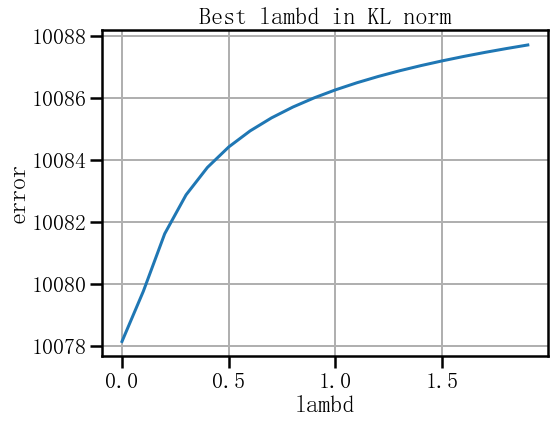

In [16]:
#TODO : find best lambda
# Using best mu and best nu observed from the graph above, 
# try different values of lambda and observe the Kullback-Leibler distance between X and WH :


lambd_list = np.arange(0.001, 2, 0.1)
lambd_min_loss = []
for i in lambd_list:
    nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler', random_state=42)
    nmf.fit_transform(data=faces.T, mu=0.001,  nu=0.001, lambd=i)
    lambd_min_loss.append(min(nmf.loss_history))

print('when lambd = {:.3}'.format(lambd_list[lambd_min_loss.index(min(lambd_min_loss))]), ' loss error is min')
plt.figure(figsize=(8,6))
plt.plot(lambd_list, lambd_min_loss)
plt.xlabel('lambd')
plt.ylabel('error')
plt.grid()
plt.title('Best lambd in KL norm');


In [17]:
# Using the optimal parameters of regularization, train the nmf model as belows:

nmf = MYNMF(n_components=20, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler',random_state=42)
nmf.fit_transform(data=faces.T, mu = 0.001,  nu=0.001, lambd=0.001)
print(min(nmf.loss_history))

10078.140463423946


### Number of components

We are going to determine the **optimal number of components** for the factorization by plotting the final loss after 100 epochs for different number of components.
We expect an **elbow curve**, and we will choose the value at the elbow point. Indeed, the higher the number of components is, the more precise the atoms of the dictionary can be, and thus the more precise the reconstructed image will be.
We will find the optimal parameter both for Frobenius and Kullback-Leibler distances.

#### Case of Frobenius distance

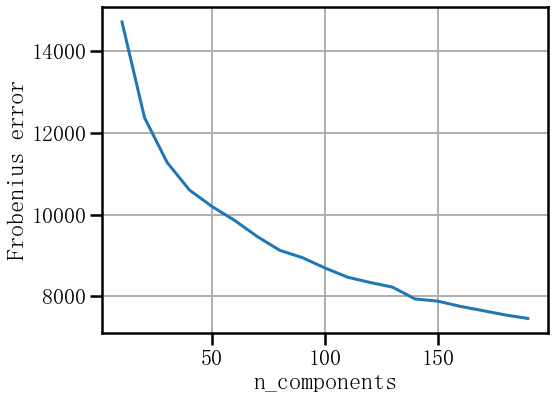

In [20]:
#TODO
# For the case of Frobenius distance, use the update rule of 'Frobenius' and norm of distance as 'Frobenius'
# Try different values of n_components, observe the Frobenius distance :

ncompo_list = range(10, 200, 10)
ncompo_min_loss = []
for i in ncompo_list:
    nmf = MYNMF(n_components=i, max_iter=100, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42)
    nmf.fit_transform(data=faces.T, mu = 0.001,  nu=0.001, lambd=0.1)
    ncompo_min_loss.append(min(nmf.loss_history))

plt.figure(figsize=(8,6))
plt.plot(ncompo_list, ncompo_min_loss)
plt.xlabel('n_components')
plt.ylabel('Frobenius error')
plt.grid()

Based on the elbow curve above, it seems that when n_components take a value of 140, the decreasing speed of loss function  becomes obviously slower. Therefore, a value of 140 is an optimal value for n_components.

#### Case of Kullback-Leibler divergence

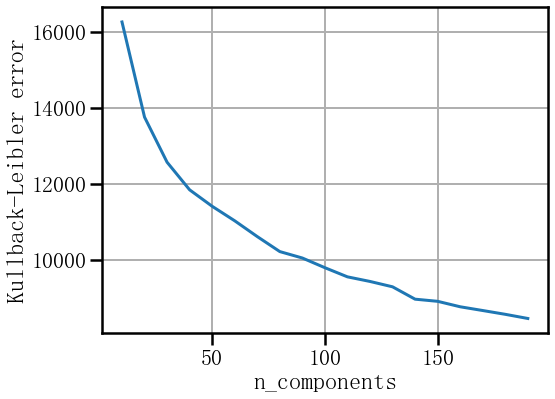

In [21]:
#TODO
# For the case of KL divergence, use update rule of 'Frobenius', norm of loss function as "Kullback-Leibler"
# # Try different values of n_components, observe the KL distance :

ncompo_list = range(10, 200, 10)
ncompo_min_loss = []
for i in ncompo_list:
    nmf = MYNMF(n_components=i, max_iter=100, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Frobenius', random_state=42)
    nmf.fit_transform(data=faces.T, mu = 0.001,  nu=0.001, lambd=0.5)
    ncompo_min_loss.append(min(nmf.loss_history))

plt.figure(figsize=(8,6))
plt.plot(ncompo_list, ncompo_min_loss)
plt.xlabel('n_components')
plt.ylabel('Kullback-Leibler error')
plt.grid()

Based on the elbow curve above, we can see that when n_components takes a value of 130, the decreasing speed of error becomes obviously slower. Therefore 130 might be an optimal value for n_component.

## Comparison between the two distances

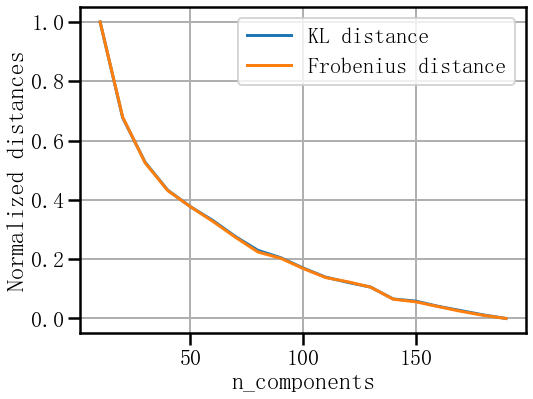

In [22]:
#TODO : plot the loss and normalized distances between S and D for different number of components

ncompo_list = range(10, 200, 10)
ncompo_min_loss_Fro = []
ncompo_min_loss_KL = []

for i in ncompo_list:
    nmf_Fro = MYNMF(n_components=i, max_iter=100, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42)
    nmf_Fro.fit_transform(data=faces.T, mu = 0.001,  nu=0.001, lambd=0.1)
    ncompo_min_loss_Fro.append(min(nmf_Fro.loss_history))
    
    nmf_KL = MYNMF(n_components=i, max_iter=100, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Frobenius', random_state=42)
    nmf_KL.fit_transform(data=faces.T, mu = 0.001,  nu=0.001, lambd=0.1)
    ncompo_min_loss_KL.append(min(nmf_KL.loss_history))

# Perform a min-max scaling here:
min_Fro = np.min(ncompo_min_loss_Fro)
max_Fro = np.max(ncompo_min_loss_Fro)
scaled_Fro = (np.array(ncompo_min_loss_Fro) - min_Fro)/(max_Fro - min_Fro)

min_KL = np.min(ncompo_min_loss_KL)
max_KL = np.max(ncompo_min_loss_KL)
scaled_KL = (np.array(ncompo_min_loss_KL) - min_KL)/(max_KL - min_KL)

plt.figure(figsize=(8,6))
plt.plot(ncompo_list, scaled_Fro)
plt.plot(ncompo_list, scaled_KL)
plt.xlabel('n_components')
plt.ylabel('Normalized distances')
plt.legend(['KL distance', 'Frobenius distance'])
plt.grid()

## Model training

### Training with Frobenius distance for different number of components

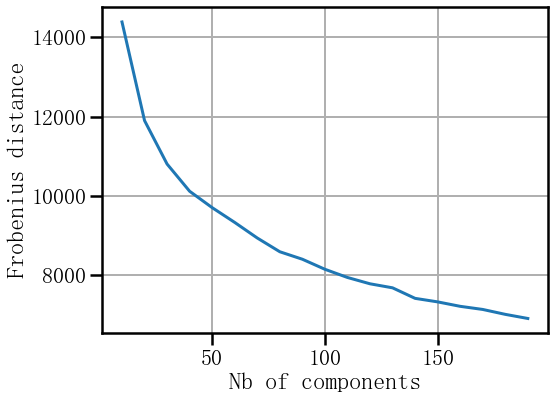

In [23]:
#TODO : Train different models for different number of components with Frobenius loss and plot loss function
# Using update rule of KL divergence, observe the Frobenius distance according to different nb of components

ncompo_list = range(10, 200, 10)
ncompo_min_loss = []
for i in ncompo_list:
    nmf = MYNMF(n_components=i, max_iter=100, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Kullback-Leibler', random_state=42)
    nmf.fit_transform(data=faces.T, mu = 0.001,  nu=0.001, lambd=0.001)
    ncompo_min_loss.append(min(nmf.loss_history))

plt.figure(figsize=(8,6))
plt.plot(ncompo_list, ncompo_min_loss)
plt.xlabel('Nb of components')
plt.ylabel('Frobenius distance')
plt.grid()

According to the elbow curve above, obviously, I think it's hard to identify very clearly the optimal value of Nb of components. It seems that when Nb of components is between 100 and 150, it's all reasonable.

### Training with KL-divergence for different number of components

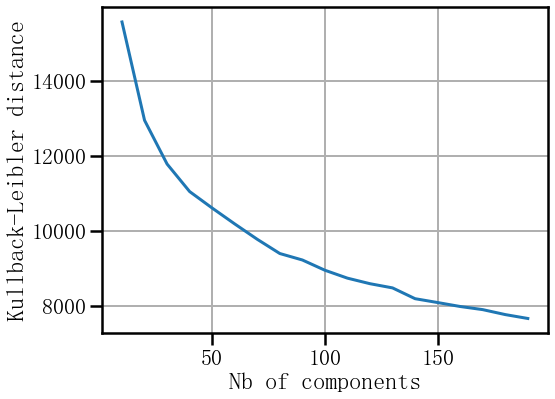

In [24]:
#TODO : Train different models for different number of components with KL divergence and plot loss function 


ncompo_list = range(10, 200, 10)
ncompo_min_loss = []
for i in ncompo_list:
    nmf = MYNMF(n_components=i, max_iter=100, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler', random_state=42)
    nmf.fit_transform(data=faces.T, mu = 0.001,  nu=0.001, lambd=0.001)
    ncompo_min_loss.append(min(nmf.loss_history))

plt.figure(figsize=(8,6))
plt.plot(ncompo_list, ncompo_min_loss)
plt.xlabel('Nb of components')
plt.ylabel('Kullback-Leibler distance')
plt.grid()

Compared with the elbow curve of Frobenius distance, similarly the optimal value of Nb of component is not very clear to see. I think that 150 might be a good choice. 

## Applications

### First application

For the first application you are going to analyse the following data to give an interpretation of the factorization:

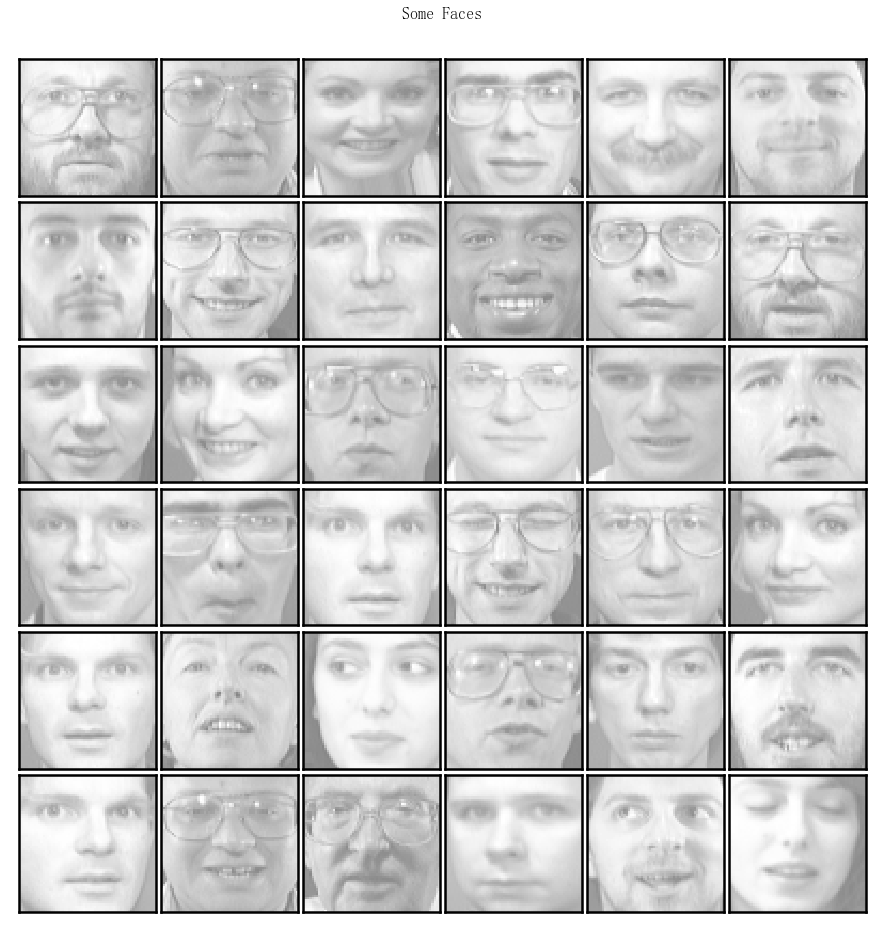

In [25]:
faces = faces.T  # n = 400 flattened images of p = 4096 = 64 x 64
image_shape = (64, 64)
n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

def plot_gallery(images, image_shape, nrow, ncol, title='', cmap=plt.cm.gray):
    
    # fit the nb of images into a square
    n_images = len(images)
    nrows = nrow
    ncols = ncol
    
    # instantiate figure
    fig, axes = plt.subplots(nrows, ncols, figsize=(2. * ncols, 2.26 * nrows))
    fig.suptitle(title, size=16)
    
    axes_for_display = axes.flatten()[:n_images]
    axes_to_blank = axes.flatten()[n_images:]
    
    for idx, comp in enumerate(images):
        ax = axes_for_display[idx]
        vmax = max(comp.max(), -comp.min())
        ax.imshow(comp.reshape(image_shape), cmap=cmap,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        ax.set(xticks=(),
               yticks=())
        
    for ax in axes_to_blank:
        ax.axis('off')

    fig.tight_layout()
    fig.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)  # insert space below the suptitle
    
plot_gallery(title="Some Faces", 
             images=faces[:36], 
             image_shape=image_shape,nrow=6,ncol=6)


### Analysis of the number of components on the reconstruction

#### Reconstruction with Frobenius distance

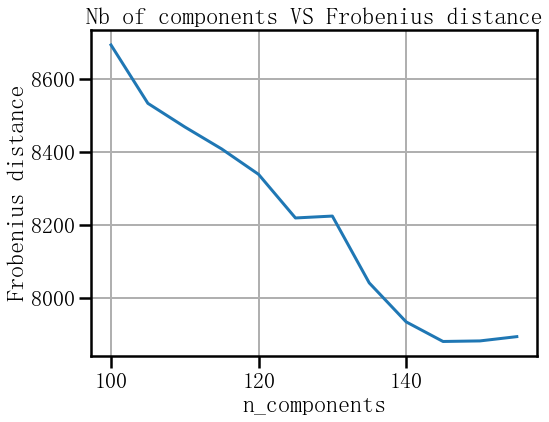

In [26]:
#TODO : plot reconstructed faces for different number of components with Frobenius distance

# Using the optimal parameters in Frobenius distance that we have found in the previous steps: mu = 0.001,  nu=0.001, lambd=0.1
# Analysing the frobenius distance when nb of components takes value between 100 and 160, 
# Since we consider an optimal n_component in this range from the results of elbow curve.

ncompo_list = range(100, 160, 5)
ncompo_min_loss = []
for i in ncompo_list:
    nmf = MYNMF(n_components=i, max_iter=100, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42)
    nmf.fit_transform(data=faces, mu = 0.001,  nu=0.001, lambd=0.1)
    ncompo_min_loss.append(min(nmf.loss_history))

plt.figure(figsize=(8,6))
plt.plot(ncompo_list, ncompo_min_loss)
plt.xlabel('n_components')
plt.ylabel('Frobenius distance')
plt.grid()
plt.title('Nb of components VS Frobenius distance');


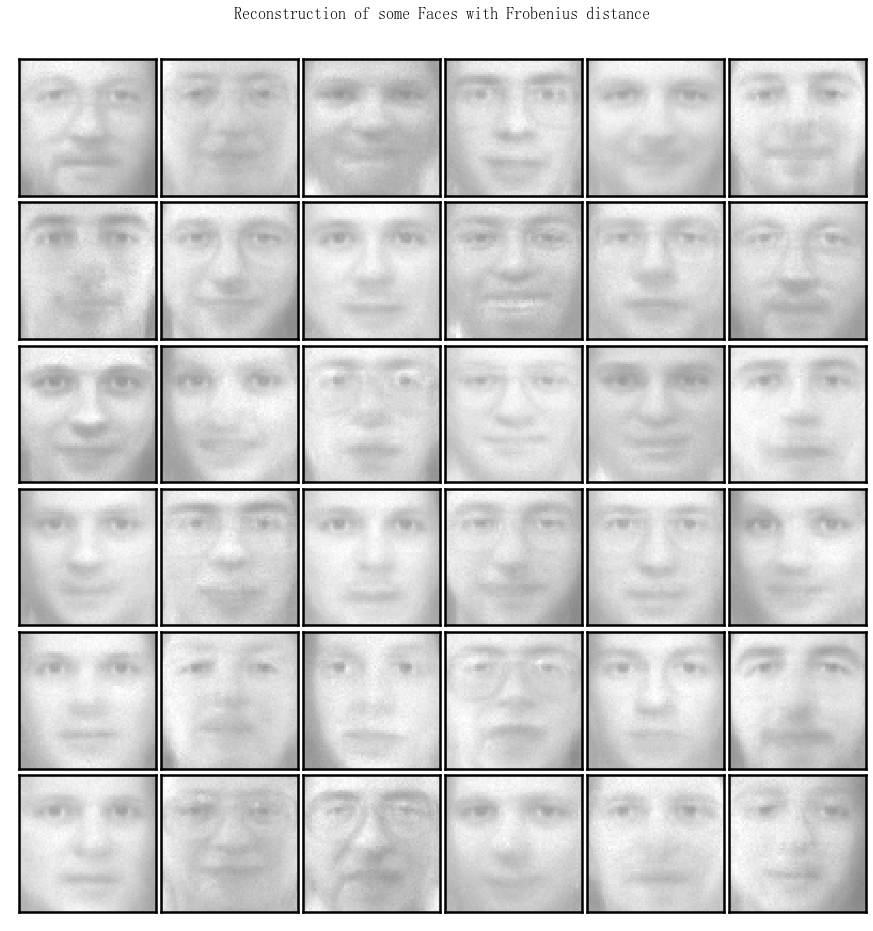

In [30]:
# Based on the elbow curve above, the optimal nb of component is approximately 130:
# Plot the pictures using this result

nmf_Fro = MYNMF(n_components=130, max_iter=100, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius',random_state=42)
nmf_Fro.fit_transform(data=faces, mu = 0.001,  nu=0.001, lambd=0.1)

image_shape = (64,64)
plot_gallery(title="Reconstruction of some Faces with Frobenius distance", 
             images= (nmf_Fro.predict_label(faces)@nmf_Fro.predict_proba(faces))[:36], 
             image_shape=image_shape,nrow=6,ncol=6)


#### Reconstruction with Kullback-Leibler divergence

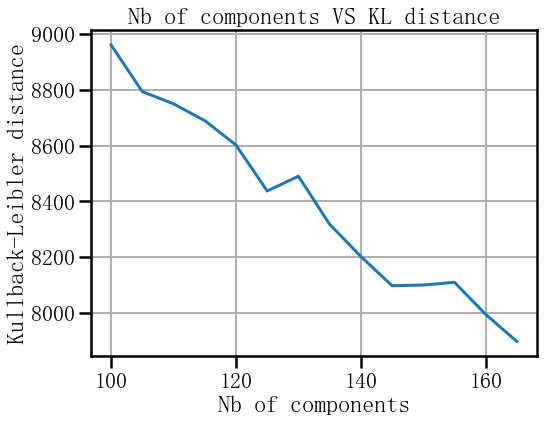

In [28]:
#TODO : plot reconstructed faces for different number of components with KL divergence

# Similarly, using the optimal parameters of regularization : mu = 0.001,  nu=0.001, lambd=0.001
# Analyze the performance when nb of components takes values between 100 and 170

ncompo_list = range(100, 170, 5)
ncompo_min_loss = []
for i in ncompo_list:
    nmf = MYNMF(n_components=i, max_iter=100, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler', random_state=42)
    nmf.fit_transform(data=faces, mu = 0.001,  nu=0.001, lambd=0.001)
    ncompo_min_loss.append(min(nmf.loss_history))

plt.figure(figsize=(8,6))
plt.plot(ncompo_list, ncompo_min_loss)
plt.xlabel('Nb of components')
plt.ylabel('Kullback-Leibler distance')
plt.grid()
plt.title('Nb of components VS KL distance');

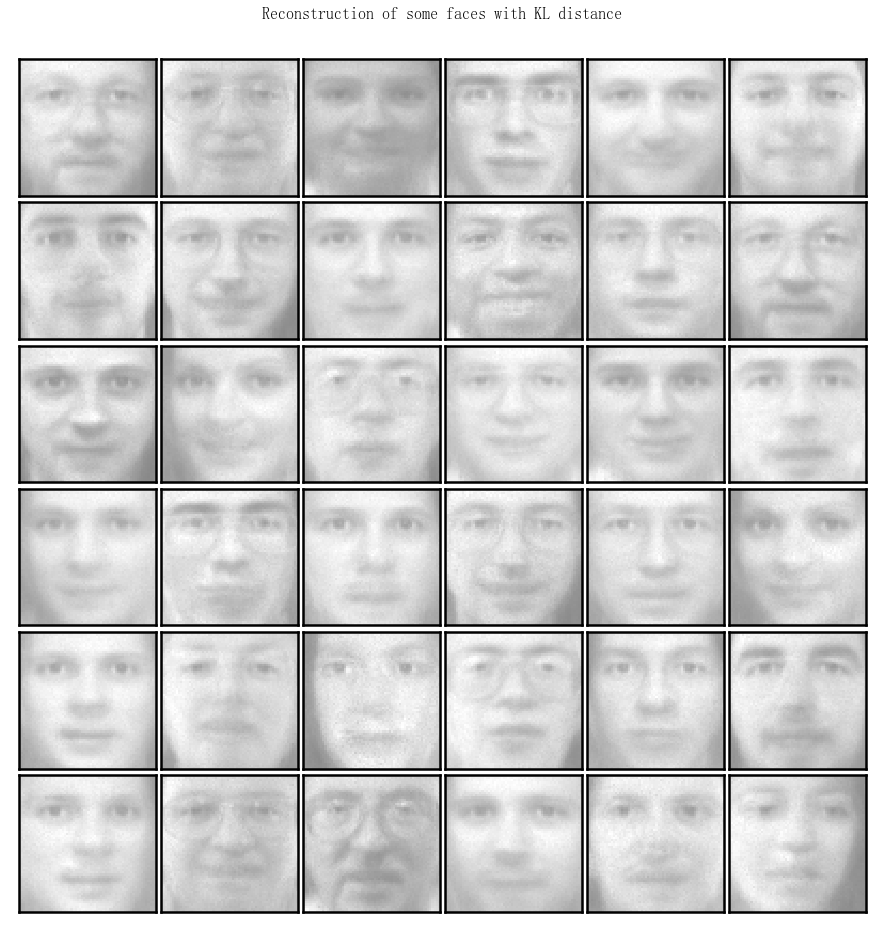

In [32]:
# Based on the elbow curve above, the optimal nb of component is approximately 150:
# Plot the pictures using this result

nmf_KL = MYNMF(n_components=150, max_iter=100, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler',random_state=42)
nmf_KL.fit_transform(data=faces, mu = 0.001,  nu=0.001, lambd=0.001)

image_shape = (64,64)
plot_gallery(title="Reconstruction of some faces with KL distance", 
             images= (nmf_KL.predict_label(faces)@nmf_KL.predict_proba(faces))[:36], 
             image_shape=image_shape,nrow=6,ncol=6)

#### Comparison of the elements of the dictionary between the two distances

In [ ]:
#TODO : plot the atoms of the dictionary for various number of components

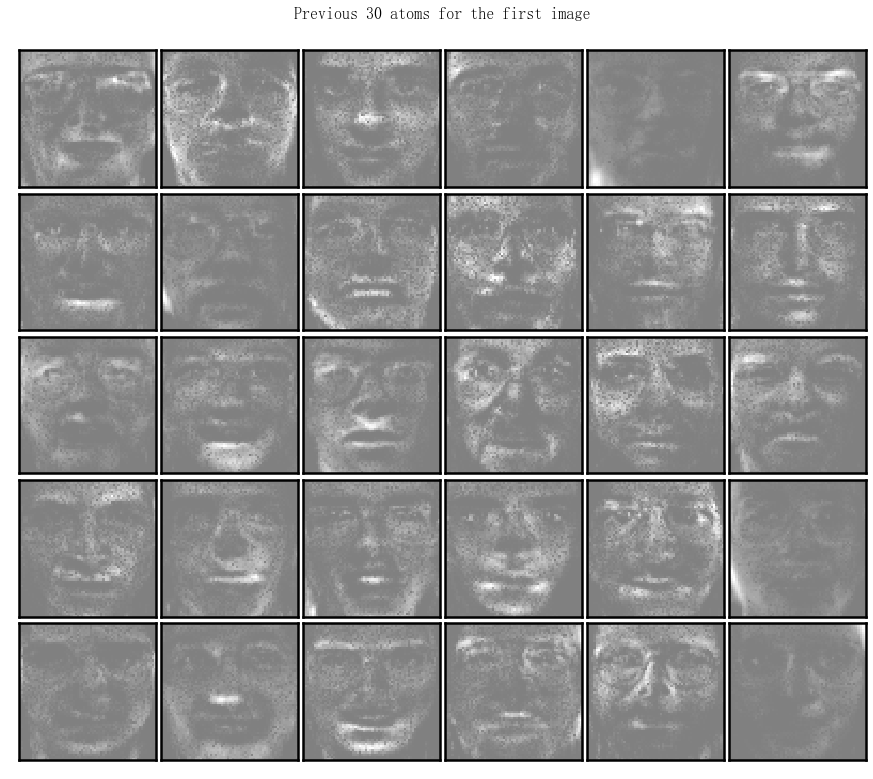

In [33]:
# In the case of Frobenius distance, plot the first 30 atoms for the first image as an example

nmf_Fro = MYNMF(n_components=130, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius',random_state=42)
nmf_Fro.fit_transform(data=faces, mu = 0.001,  nu=0.001, lambd=0.1)

W = nmf_Fro.predict_label(faces)
H = nmf_Fro.predict_proba(faces)

image_shape = (64,64)
new_image = W[0,0]*H[0,:]
for i in range(1,30):
    new_image = np.vstack((new_image, W[0,i]*H[i,:]))
plot_gallery(title="Previous 30 atoms for the first image", 
             images=new_image, 
             image_shape=image_shape,nrow=5,ncol=6)

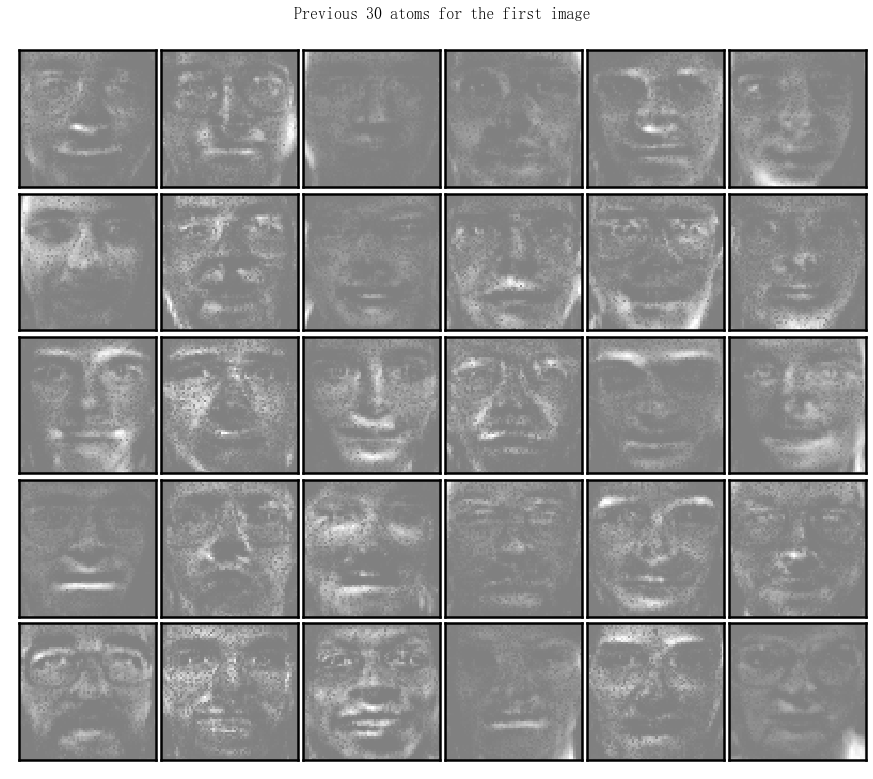

In [34]:
# In the case of KL distance, plot the first 30 atoms for the first image as an example :

nmf_KL = MYNMF(n_components=150, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler',random_state=42)
nmf_KL.fit_transform(data=faces, mu = 0.001,  nu=0.001, lambd=0.001)

W = nmf_KL.predict_label(faces)
H = nmf_KL.predict_proba(faces)

image_shape = (64,64)
new_image = W[0,0]*H[0,:]
for i in range(1,30):
    new_image = np.vstack((new_image, W[0,i]*H[i,:]))
plot_gallery(title="Previous 30 atoms for the first image", 
             images=new_image, 
             image_shape=image_shape,nrow=5,ncol=6)

### Study of the clustering for the Frobenius distance with 30 components

Now, we are going to clusterise the images in r different classes. First, we start by normalizing the norm of the dictionary elements, so that the euclidian norm = 1, and we multiply the associated row in the S matrix to preserve the factorization DS = X. Then, we find the highest coefficient for each image, and we use the index of the maximum as clustering label.

In [ ]:
#TODO : Study the clustering

In [35]:
nmf_Fro = MYNMF(n_components=30, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius',random_state=42)
nmf_Fro.fit_transform(data=faces, mu = 0.001,  nu=0.001, lambd=0.1)

W = nmf_Fro.predict_label(faces)
H = nmf_Fro.predict_proba(faces)


In [36]:
# Create a function which returns the clustering label:
def cluster_label(W):
    
    # Normalize the norm of dictionary elements:
    W_norm = W.copy()
    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            distance = np.sqrt(np.sum(W[:,j] **2))
            W_norm[i,j] = W[i,j]/distance
    
    # Find the highest coefficient for each image :
    faces_cluster = W_norm
    labels = []
    for i in range(faces_cluster.shape[0]):
        label = np.where((faces_cluster[i]==max(faces_cluster[i])))
        labels.append(label[0][0])
    # Return a list with labels for each sample
    return labels

In [37]:
print(cluster_label(W)[:36])

[11, 24, 6, 19, 16, 27, 4, 14, 6, 28, 0, 0, 16, 9, 25, 17, 14, 20, 5, 13, 21, 8, 26, 5, 22, 21, 19, 25, 19, 2, 15, 24, 18, 20, 18, 12]


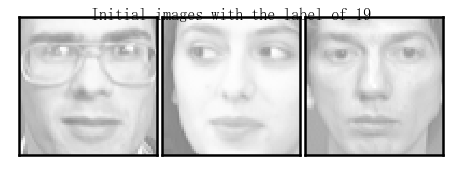

In [38]:
# Visualization of clustering results:
# Observe the initail images with the same label : 19 as an example:

image_shape = (64,64)
index_label19 = np.where(np.array(cluster_label(W))[:36] == 19)[0]
image_label19 = faces[index_label19]

plot_gallery(title="Initial images with the label of 19", 
             images=image_label19, 
             image_shape=image_shape,nrow=1,ncol=3)

### Second application 

Import the 20newsgroups dataset (from sklearn.datasets import fetch_20newsgroups_vectorized) that contains a collection of ~18,000 newsgroup documents from 20 different newsgroups.

Model the topics present in a subsample with *scikit-learn's* NMF. Print the most common words of each topic. 

Discuss.

In [39]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from pprint import pprint
from sklearn.feature_extraction import text

n_samples = 2000
n_features = 1000
n_topics = 10
n_top_words = 20

data, _ = fetch_20newsgroups(shuffle=True,random_state=1,remove=("headers", "footers", "quotes"),return_X_y=True)

data_samples = data[:n_samples]

In [40]:
# Convert text to vectors:

vectorizer = text.CountVectorizer(max_df=0.95, max_features=n_features)
counts = vectorizer.fit_transform(data[:n_samples])
tfidf = text.TfidfTransformer().fit_transform(counts)
tfidf = tfidf.toarray()

### Case of Frobenius distance

when mu = 0.001  loss error is min
when nu = 0.601  loss error is min
when lambd = 0.001  loss error is min


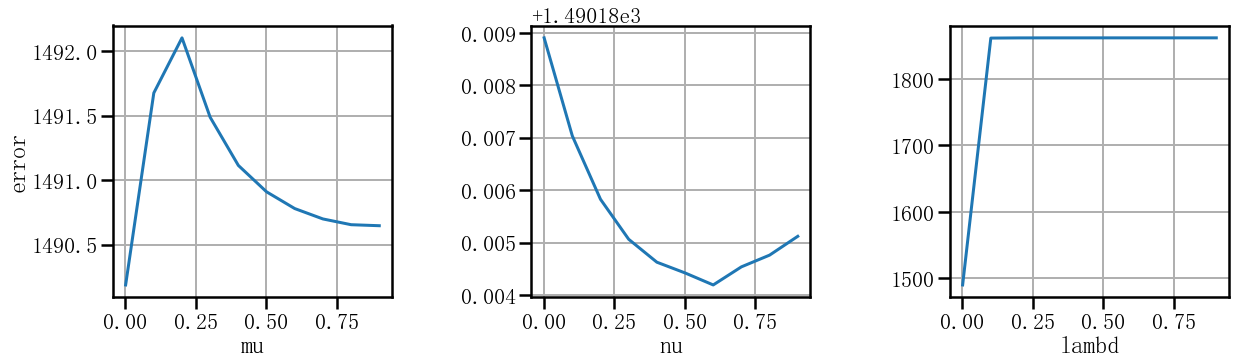

In [42]:
# Find optimal regularization parameters of NMF model using Frobenius distance


parameters = np.arange(0.001, 1, 0.1)
min_loss = []
ax,fig =plt.subplots(figsize=(20,5))
plt.subplots_adjust(wspace=0.5, hspace=0.2)

for i in parameters:
    nmf = MYNMF(n_components=n_topics, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42)
    nmf.fit_transform(data=tfidf, mu=i,  nu=0.001, lambd=0.001)
    min_loss.append(min(nmf.loss_history))
print('when mu = {:.3}'.format(parameters[min_loss.index(min(min_loss))]), ' loss error is min')
plt.subplot(1,3,1)
plt.plot(parameters, min_loss)
plt.xlabel('mu')
plt.ylabel('error')
plt.grid()
min_loss.clear()

for i in parameters:
    nmf = MYNMF(n_components=n_topics, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42)
    nmf.fit_transform(data=tfidf, mu=0.001,  nu=i, lambd=0.001)
    min_loss.append(min(nmf.loss_history))
print('when nu = {:.3}'.format(parameters[min_loss.index(min(min_loss))]), ' loss error is min')
plt.subplot(1,3,2)
plt.plot(parameters, min_loss)
plt.xlabel('nu')
#plt.ylabel('error')
plt.grid()
#plt.title('Best regularization parameters in Frobenius norm')
min_loss.clear()

for i in parameters:
    nmf = MYNMF(n_components=n_topics, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius', random_state=42)
    nmf.fit_transform(data=tfidf, mu=0.001,  nu=0.001, lambd=i)
    min_loss.append(min(nmf.loss_history))
print('when lambd = {:.3}'.format(parameters[min_loss.index(min(min_loss))]), ' loss error is min')
plt.subplot(1,3,3)
plt.plot(parameters, min_loss)
plt.xlabel('lambd')
#plt.ylabel('error')
plt.grid()


plt.show()

In [43]:
# Fit the Frobenius NMF model using optimal parameters obtained from the analysis above:
nmftopic_Fro = MYNMF(n_components=n_topics, max_iter=200, epsilon = 1e-5, loss = "Frobenius", update_rule = 'Frobenius',random_state=42)
nmftopic_Fro.fit_transform(data=tfidf, mu = 0.001,  nu=0.600, lambd=0.001)
W_topic = nmftopic_Fro.predict_label(tfidf)
H_topic = nmftopic_Fro.predict_proba(tfidf)

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

# Print the top 20 words in 10 topics:
for topic_idx, topic in enumerate(H_topic):
    print("Topic #%d:" % (topic_idx+1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print

Topic #1:
you your if re can are get don do for so at have then see want or ll from just
Topic #2:
he his and him god who to with will we good know has jesus said got all for because ll
Topic #3:
was the in were this had game at my did they on that thought when year an she years there
Topic #4:
for thanks me please anyone any and windows mail or am have with card my know edu email looking advance
Topic #5:
to be this my would and as use of do key want can from have going up get like we
Topic #6:
that they not have be are would we do to so will their people think and say if but all
Topic #7:
is there this that the not what in an are only as one has no which it where think does
Topic #8:
of the in and as are for by one people us most their that were from other being or number
Topic #9:
it but just too on and like that can to don doesn good no with ve my isn really some
Topic #10:
the and on with in will at to from up same back first for only power into when problem little


### Case of KL divergence distance:

when mu = 0.901  loss error is min
when nu = 0.901  loss error is min
when lambd = 0.901  loss error is min


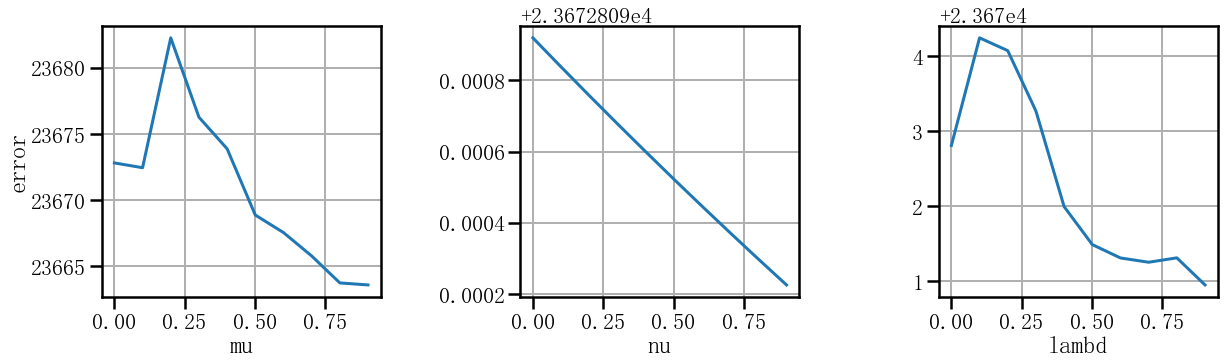

In [44]:
# Find optimal regularization parameters of NMF model using KL distance

parameters = np.arange(0.001, 1, 0.1)
min_loss = []
ax,fig =plt.subplots(figsize=(20,5))
plt.subplots_adjust(wspace=0.5, hspace=0.2)

for i in parameters:
    nmf = MYNMF(n_components=n_topics, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler', random_state=42)
    nmf.fit_transform(data=tfidf, mu=i,  nu=0.001, lambd=0.001)
    min_loss.append(min(nmf.loss_history))
print('when mu = {:.3}'.format(parameters[min_loss.index(min(min_loss))]), ' loss error is min')
plt.subplot(1,3,1)
plt.plot(parameters, min_loss)
plt.xlabel('mu')
plt.ylabel('error')
plt.grid()
min_loss.clear()

for i in parameters:
    nmf = MYNMF(n_components=n_topics, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler', random_state=42)
    nmf.fit_transform(data=tfidf, mu=0.001,  nu=i, lambd=0.001)
    min_loss.append(min(nmf.loss_history))
print('when nu = {:.3}'.format(parameters[min_loss.index(min(min_loss))]), ' loss error is min')
plt.subplot(1,3,2)
plt.plot(parameters, min_loss)
plt.xlabel('nu')
#plt.ylabel('error')
plt.grid()
#plt.title('Best regularization parameters in Kullback-Leibler norm')
min_loss.clear()

for i in parameters:
    nmf = MYNMF(n_components=n_topics, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler', random_state=42)
    nmf.fit_transform(data=tfidf, mu=0.001,  nu=0.001, lambd=i)
    min_loss.append(min(nmf.loss_history))
print('when lambd = {:.3}'.format(parameters[min_loss.index(min(min_loss))]), ' loss error is min')
plt.subplot(1,3,3)
plt.plot(parameters, min_loss)
plt.xlabel('lambd')
#plt.ylabel('error')
plt.grid()


plt.show()

In [45]:
# Fit the KL NMF model using optimal parameters obtained from the analysis above:
nmftopic_KL = MYNMF(n_components=n_topics, max_iter=200, epsilon = 1e-5, loss = "Kullback-Leibler", update_rule = 'Kullback-Leibler',random_state=42)
nmftopic_KL.fit_transform(data=tfidf, mu = 0.900,  nu=0.9, lambd=0.9)
W_topic = nmftopic_KL.predict_label(tfidf)
H_topic = nmftopic_KL.predict_proba(tfidf)

# Inverse the vectorizer vocabulary to be able
feature_names = vectorizer.get_feature_names()

# Print the top 20 words in 10 topics:
for topic_idx, topic in enumerate(H_topic):
    print("Topic #%d:" % (topic_idx+1))
    print(" ".join([feature_names[i]
                    for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print



Topic #1:
you to the it your that is if they not and can do be don are so re of just
Topic #2:
the was had to in of it were that he this game heard thought before and remember they but she
Topic #3:
the and my to it with got car out of in on better have bike up good all that for
Topic #4:
for drive edu pc 00 10 software card sale mac and with new 15 16 mail 30 contact drives 20
Topic #5:
the to of someone government could chip be key it in tell win is that can etc and there number
Topic #6:
the of is to and in space as by data for from be this system it that which an are
Topic #7:
thanks the to anyone any please windows for me file is am have help and on know or this my
Topic #8:
the of that to is and in not people are we his as god he who by be our have
Topic #9:
the in and list on for he general who news job play will home at world black of white be
Topic #10:
the and of in stuff are by based state to on deleted israel you call 000 all talk media they
